##### Use of 'Table of Contents 2' [toc2/main] notebook extension is highly recommended.

## Imports

In [1]:
import re
import itertools
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from umap import UMAP

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.options.display.max_columns = 100

# Read data

In [3]:
data_original = pd.read_csv('data/beer_basic_data.csv', index_col='Unnamed: 0')
data_original = data_original.rename(columns={'size': 'final_size', 'style': 'beer_style'})
data_original.head()

title                      beer_style  \
0        Sierra Nevada Pale Ale Clone               American Pale Ale   
1  Avg. Perfect Northeast IPA (NEIPA)  Specialty IPA: New England IPA   
2       Zombie Dust Clone - ALL GRAIN                    American IPA   
3         Zombie Dust Clone - EXTRACT                    American IPA   
4       Simple Citra IPA - One Gallon                    American IPA   

   final_size   ABV    IBU     OG     FG  color     method   views  brewed  \
0        6.50  5.58  40.12  1.055  1.013   8.00  All Grain  224412     556   
1        5.75  6.50  50.60  1.062  1.013   5.20  All Grain  231660     280   
2        6.00  5.94  54.57  1.061  1.016   8.50  All Grain  191290     191   
3        5.00  6.16  64.77  1.063  1.016   8.98    Extract  176309     155   
4        1.00  6.10  37.06  1.058  1.011  11.45  All Grain   44521     123   

   rating size_unit   author           author_name  boil_size  boil_time  \
0    4.79       Gal   5889.0  Ozarks Mountain Brew       7.75         70   
1    4.65       Gal  49801.0                kcq101       7.50         60   
2    4.66       Gal      NaN  Players Only Brewing       7.00         60   
3    4.62       Gal      NaN  Players Only Brewing       6.00         60   
4    4.79       Gal  45128.0               enrique       1.50         60   

   boil_grav  pitch_rate  temp_prim temp_unit prim_method prim_amount  \
0      1.047        1.00        NaN       NaN         NaN         NaN   
1      1.048         NaN        NaN       NaN        Keg          NaN   
2      1.053         NaN        NaN       NaN         NaN         NaN   
3      1.052         NaN        NaN       NaN         NaN         NaN   
4      1.039        0.35       65.0         F         NaN         NaN   

  prim_amount_unit        creation_date  \
0              NaN  12/27/2012 09:03 PM   
1              NaN  05/31/2016 02:52 PM   
2              NaN  03/29/2012 02:27 PM   
3              NaN  03/29/2012 02:52 PM   
4              NaN  04/02/2015 06:03 PM   

                                            url_beer  \
0  https://www.brewersfriend.com/homebrew/recipe/...   
1  https://www.brewersfriend.com/homebrew/recipe/...   
2  https://www.brewersfriend.com/homebrew/recipe/...   
3  https://www.brewersfriend.com/homebrew/recipe/...   
4  https://www.brewersfriend.com/homebrew/recipe/...   

                                           url_style  \
0  https://www.brewersfriend.com/styles/american-...   
1  https://www.brewersfriend.com/styles/specialty...   
2  https://www.brewersfriend.com/styles/american-...   
3  https://www.brewersfriend.com/styles/american-...   
4  https://www.brewersfriend.com/styles/american-...   

                                          url_author  efficiency  mash_thick  \
0  https://www.brewersfriend.com/homebrew/brewer/...          79         NaN   
1  https://www.brewersfriend.com/homebrew/brewer/...          70        1.25   
2                                                NaN          70         NaN   
3                                                NaN          70         NaN   
4  https://www.brewersfriend.com/homebrew/brewer/...          55        1.50   

        sugar_scale  
0  Specific Gravity  
1  Specific Gravity  
2  Specific Gravity  
3  Specific Gravity  
4  Specific Gravity

In [4]:
data_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7179 entries, 0 to 7178
Data columns (total 31 columns):
title               7179 non-null object
beer_style          7179 non-null object
final_size          7179 non-null float64
ABV                 7179 non-null float64
IBU                 7179 non-null float64
OG                  7179 non-null float64
FG                  7179 non-null float64
color               7179 non-null float64
method              7179 non-null object
views               7179 non-null int64
brewed              7179 non-null int64
rating              7179 non-null float64
size_unit           7179 non-null object
author              4808 non-null float64
author_name         6279 non-null object
boil_size           7179 non-null float64
boil_time           7179 non-null int64
boil_grav           6692 non-null float64
pitch_rate          4371 non-null float64
temp_prim           4879 non-null float64
temp_unit           4879 non-null object
prim_method         111

In [5]:
data_details = pd.read_csv('data/beer_detail_info.csv', index_col='Unnamed: 0')
data_details.head()

reviews calories calories_unit  carbs carbs_unit  mash_ph
0       25      182      calories     18          g     5.67
1       20      204      calories     19          g     5.49
2        9      203      calories     22          g     5.81
3        8      208      calories     22          g     5.41
4        5      190      calories     17          g      NaN

In [6]:
data_details.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7179 entries, 0 to 7178
Data columns (total 6 columns):
reviews          7179 non-null int64
calories         7179 non-null object
calories_unit    7179 non-null object
carbs            7179 non-null int64
carbs_unit       7179 non-null object
mash_ph          1364 non-null float64
dtypes: float64(1), int64(2), object(3)
memory usage: 392.6+ KB


In [223]:
(data_details.reviews > 1).sum()

90

# Clean data

## Drop columns

In [7]:
data = pd.merge(data_original, data_details, left_index=True, right_index=True)

# not important
data.drop(columns=['url_beer', 'url_style', 'url_author', 'creation_date', 'author', 'author_name'], inplace=True)

# too many nans
data['has_prim_data'] = ((data.prim_amount.isna() == False) | 
                         (data.prim_method.isna() == False) | 
                         (data.prim_amount_unit == False)).astype(int)
data.drop(columns=['prim_amount', 'prim_method', 'prim_amount_unit'], inplace=True)

data['has_mash_ph'] = (data.mash_ph.isna() == False).astype(int)
# data.drop(columns=['mash_ph'], inplace=True)

data['has_mash_thick'] = (data.mash_thick.isna() == False).astype(int)
# data.drop(columns=['mash_thick'], inplace=True)

data['has_pitch_rate'] = (data.pitch_rate.isna() == False).astype(int)
# data.drop(columns=['pitch_rate'], inplace=True)

# has only 1 value
data.drop(columns=['calories_unit', 'carbs_unit'], inplace=True)
data['calories'] = data.calories.str.replace(',','').astype(int)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7179 entries, 0 to 7178
Data columns (total 30 columns):
title             7179 non-null object
beer_style        7179 non-null object
final_size        7179 non-null float64
ABV               7179 non-null float64
IBU               7179 non-null float64
OG                7179 non-null float64
FG                7179 non-null float64
color             7179 non-null float64
method            7179 non-null object
views             7179 non-null int64
brewed            7179 non-null int64
rating            7179 non-null float64
size_unit         7179 non-null object
boil_size         7179 non-null float64
boil_time         7179 non-null int64
boil_grav         6692 non-null float64
pitch_rate        4371 non-null float64
temp_prim         4879 non-null float64
temp_unit         4879 non-null object
efficiency        7179 non-null int64
mash_thick        4069 non-null float64
sugar_scale       7179 non-null object
reviews           7179 non-

## Standardize unit of measure

### primary temperature

In [9]:
data.temp_unit.unique()

array([nan, ' F', ' C'], dtype=object)

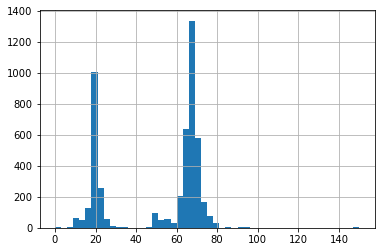

In [10]:
data_original.temp_prim.hist(bins=50)

In [11]:
def fahrenheit2celsius(f):
    return (f - 32) * 5.0/9.0

data.loc[data.temp_unit == ' F', 'temp_prim'] = data_original[data.temp_unit == ' F'].temp_prim.apply(fahrenheit2celsius)

In [185]:
data[data.temp_prim < 0]

title  final_size   ABV    IBU     OG     FG  color  \
648          Hard Knocks Marzen   20.819765  5.03  23.38  1.054  1.016   9.80   
1606                  Oli's IPA   18.927059  7.26  85.68  1.066  1.011  10.87   
1768         1912 Olympia clone   20.819765  5.54  29.94  1.055  1.012   3.02   
2270         Gold Rush Pale Ale   20.819765  5.51  39.05  1.053  1.011   5.56   
2307  Caribou Slobber Brown Ale   18.927059  4.75  36.57  1.050  1.014  19.72   
2911    Tony Brown Ale 08-15-19   15.520188  4.68  30.95  1.052  1.016  20.15   
3090           Rovers Rally Ale   22.712471  5.69  30.36  1.058  1.015   8.37   
3445     Jay's Chocolate Orange   20.819765  7.01  37.10  1.073  1.020  18.65   
4220    Belgian Dark and Strong   23.091012  8.83  42.40  1.083  1.016  12.51   
4264          Eggnog Milk Stout    3.785412  4.79  28.34  1.052  1.016  39.63   
4632                    Riptide   18.927059  9.55  87.29  1.094  1.021  50.00   
5254                Sweet Stout   18.927059  5.66  24.09  1.072  1.029  41.21   
5680        Tankhouse Ale Clone   18.927059  3.94  49.91  1.039  1.009  11.74   
5709            Tub Springs IPA   37.854118  6.12  71.26  1.062  1.016   6.29   
6067        Epic Pale Ale Clone   20.819765  6.04  46.38  1.060  1.014   8.68   
6721                 Brown Nuts   41.639530  5.26  24.39  1.056  1.016  29.48   

      views  brewed  rating  boil_size  boil_time  boil_grav  pitch_rate  \
648    1219       5     0.0  27.936339         60      1.040        1.50   
1606     65       3     0.0  15.141647         60      1.083        0.35   
1768   1974       3     0.0  26.497882         90      1.043        0.50   
2270    515       3     0.0  26.497882         60      1.042        0.75   
2307    596       3     0.0  26.497882         60      1.036        0.50   
2911    148       2     0.0  19.873412         60      1.040        0.35   
3090     49       2     0.0  28.390588         60      1.046        0.35   
3445    100       2     0.0  28.390588         60      1.054        0.50   
4220    231       2     0.0  24.983718         60      1.077         NaN   
4264    660       2     0.0   4.731765         60      1.042         NaN   
4632    506       2     0.0  28.390588         60      1.063         NaN   
5254    384       2     0.0  24.605177         60      1.055         NaN   
5680    858       2     0.0  26.497882         60      1.028         NaN   
5709    539       2     0.0  45.424941         60      1.052         NaN   
6067   1743       2     0.0  24.605177         60      1.051        0.50   
6721    633       2     0.0  49.210353         60      1.047         NaN   

      temp_prim  efficiency  mash_thick  reviews  calories  carbs  mash_ph  \
648  -10.694444          70        1.75        0       179     20      NaN   
1606  -5.555556          35         NaN        0       216     18     4.04   
1768 -17.777778          80        1.80        0       181     18      NaN   
2270 -17.777778          80        1.30        0       174     16      NaN   
2307 -17.777778          65        1.50        0       166     18      NaN   
2911 -17.777778          50        1.40        0       174     20     5.36   
3090 -14.444444          70        1.50        0       192     20      NaN   
3445  -7.222222          80        1.50        0       243     26      NaN   
4220  -1.111111          70        0.70        0       274     25      NaN   
4264  -6.111111          75        1.50        0       174     20      NaN   
4632  -7.222222          70        1.50        0       313     30      NaN   
5254 -12.222222          65        1.55        0       244     33      NaN   
5680  -4.444444          55        3.00        0       128     13      NaN   
5709 -17.777778          70        1.50        0       206     22      NaN   
6067 -17.777778          70        1.30        0       198     20      NaN   
6721  -9.444444          35         NaN        0       186     21      NaN   

      has_prim_data  has_mas

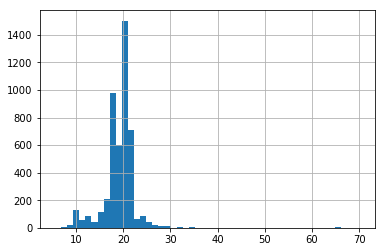

In [180]:
data[data.temp_prim > 0].temp_prim.hist(bins=50)

In [187]:
data.drop(columns=['temp_unit'], inplace=True)
# data.loc[data.temp_prim.isna() == True, ['temp_prim']] = -99
data.drop(index=data[(data.temp_prim > 40) | (data.temp_prim < 0)].index, inplace=True)

### size

In [14]:
data.size_unit.unique()

array(['Gal', 'L'], dtype=object)

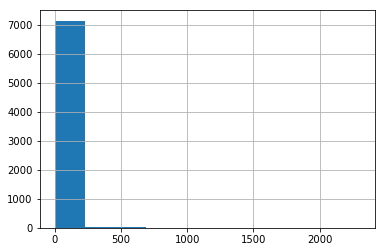

In [15]:
data_original.final_size.hist()

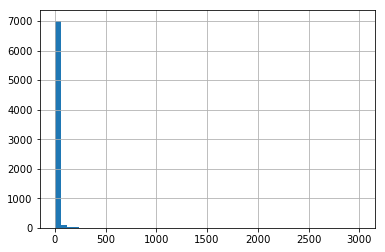

In [16]:
data_original.boil_size.hist(bins=50)

In [17]:
data.loc[data.size_unit == 'Gal', ['boil_size']] = data[data.size_unit == 'Gal'].boil_size * 3.785411784
data.loc[data.size_unit == 'Gal', ['final_size']] = data[data.size_unit == 'Gal'].final_size * 3.785411784

In [18]:
data.drop(columns=['size_unit'], inplace=True)

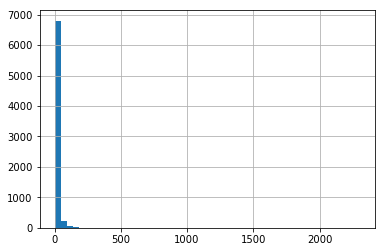

In [19]:
data.final_size.hist(bins=50)

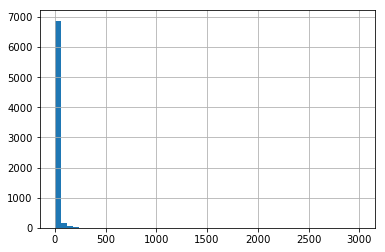

In [20]:
data.boil_size.hist(bins=50)

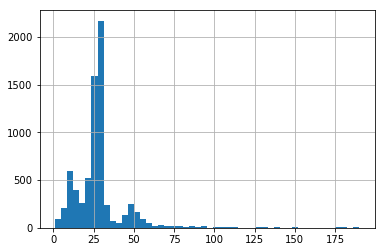

In [21]:
data[data.boil_size < 200].boil_size.hist(bins=50)

Boil size should not matter anyway...

### sugar scale

In [22]:
data.sugar_scale.unique()

array(['Specific Gravity', 'Plato'], dtype=object)

In [23]:
data.sugar_scale.value_counts()

Specific Gravity    7005
Plato                174
Name: sugar_scale, dtype: int64

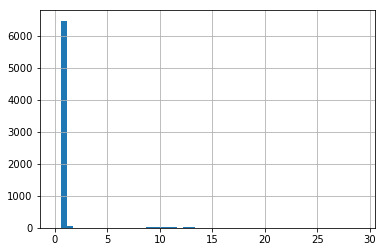

In [24]:
data_original.boil_grav.hist(bins=50)

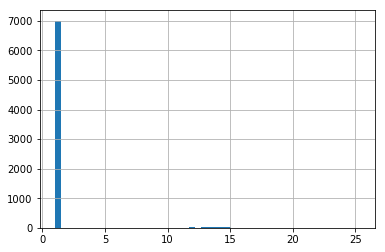

In [25]:
data_original.OG.hist(bins=50)

In [26]:
def plato2sg(plato):
    return 1 + (plato / (258.6 - ( (plato/258.2) *227.1) ) )
data.loc[data.sugar_scale == 'Plato', ['OG']] = data[data.sugar_scale == 'Plato'].OG.apply(plato2sg)
data.loc[data.sugar_scale == 'Plato', ['FG']] = data[data.sugar_scale == 'Plato'].FG.apply(plato2sg)
data.loc[data.sugar_scale == 'Plato', ['boil_grav']] = data[data.sugar_scale == 'Plato'].boil_grav.apply(plato2sg)

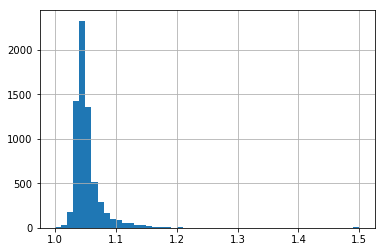

In [27]:
data.boil_grav.hist(bins=50)

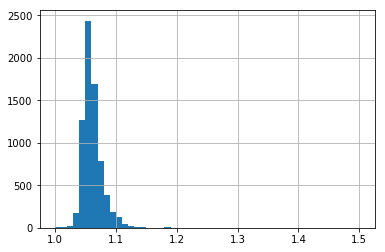

In [28]:
data.OG.hist(bins=50)

In [29]:
data.drop(columns=['sugar_scale'], inplace=True)

In [30]:
# data.loc[data.boil_grav.isna(), ['boil_grav']] = -1

## Categorical variables

In [31]:
data.select_dtypes('object')

title                      beer_style  \
0           Sierra Nevada Pale Ale Clone               American Pale Ale   
1     Avg. Perfect Northeast IPA (NEIPA)  Specialty IPA: New England IPA   
2          Zombie Dust Clone - ALL GRAIN                    American IPA   
3            Zombie Dust Clone - EXTRACT                    American IPA   
4          Simple Citra IPA - One Gallon                    American IPA   
...                                  ...                             ...   
7174               American Pale Ale FWH               American Pale Ale   
7175                  Pliney and Friends                    Imperial IPA   
7176         Conrad's Oatmeal Milk Stout                     Sweet Stout   
7177                          Double IPA                    Imperial IPA   
7178              This is my beer recipe          California Common Beer   

         method  
0     All Grain  
1     All Grain  
2     All Grain  
3       Extract  
4     All Grain  
...         ...  
7174  All Grain  
7175       BIAB  
7176  All Grain  
7177  All Grain  
7178  All Grain  

[7179 rows x 3 columns]

### method

In [32]:
data.method.value_counts()

All Grain       4854
BIAB            1276
Extract          783
Partial Mash     266
Name: method, dtype: int64

In [33]:
data['method'] = data.method.str.replace(' ','')

In [34]:
data = pd.get_dummies(data, 
                      prefix='method',
                      columns=['method']
                     )

In [90]:
method_cols = list(data.columns[data.columns.str.match('method_')])

### style

#### detail (beer_style)

In [204]:
style_counts = data.beer_style.value_counts()
style_counts[:40]

AmericanIPA                       1172
AmericanPaleAle                    715
BlondeAle                          211
AmericanAmberAle                   199
Saison                             194
AmericanStout                      143
Witbier                            128
ImperialIPA                        121
OatmealStout                       117
AmericanLightLager                 115
IrishRedAle                        114
Weissbier                          112
SpecialtyIPA:NewEnglandIPA         110
CreamAle                           109
SweetStout                         108
Weizen/Weissbier                   104
RobustPorter                       101
AmericanBrownAle                   101
Kölsch                              99
RussianImperialStout                84
AmericanWheatBeer                   83
FruitBeer                           74
ImperialStout                       66
AmericanPorter                      62
EnglishIPA                          59
BelgianTripel            

In [109]:
data['beer_style'] = data.beer_style.str.replace(' ', '')

In [206]:
n_styles = 20
threshold = style_counts[n_styles - 1]
threshold = 84

under_threshold = data.beer_style.apply(lambda style: style in style_counts.index[style_counts < threshold])
percent = len(data[under_threshold]) / len(data)

print(f'{100 * percent:.2f}% of data has style with less then {threshold} occurances.')
print(f'{100 * (1 - percent):.2f}% of data is covered by {(style_counts >= threshold).sum()} styles.')


39.87% of data has style with less then 84 occurances.
60.13% of data is covered by 20 styles.


In [207]:
style_counts.index[style_counts >= threshold]

Index(['AmericanIPA', 'AmericanPaleAle', 'BlondeAle', 'AmericanAmberAle',
       'Saison', 'AmericanStout', 'Witbier', 'ImperialIPA', 'OatmealStout',
       'AmericanLightLager', 'IrishRedAle', 'Weissbier',
       'SpecialtyIPA:NewEnglandIPA', 'CreamAle', 'SweetStout',
       'Weizen/Weissbier', 'RobustPorter', 'AmericanBrownAle', 'Kölsch',
       'RussianImperialStout'],
      dtype='object')

In [121]:
data.drop(columns=data.columns[data.columns.str.match('style_')], inplace=True)
data['style_under_threshold'] = under_threshold.astype(int)
data.loc[under_threshold, ['beer_style']] = np.nan
data = pd.get_dummies(data,
              prefix='style',
              columns=['beer_style'])
data['beer_style'] = pd.read_csv('data/beer_basic_data.csv')['style'].str.replace(' ','')
style_cols = list(data.columns[data.columns.str.match('style_')])

In [122]:
style_cols

['style_under_threshold',
 'style_AmericanAmberAle',
 'style_AmericanBrownAle',
 'style_AmericanIPA',
 'style_AmericanLightLager',
 'style_AmericanPaleAle',
 'style_AmericanStout',
 'style_BlondeAle',
 'style_CreamAle',
 'style_ImperialIPA',
 'style_IrishRedAle',
 'style_Kölsch',
 'style_OatmealStout',
 'style_RobustPorter',
 'style_RussianImperialStout',
 'style_Saison',
 'style_SpecialtyIPA:NewEnglandIPA',
 'style_SweetStout',
 'style_Weissbier',
 'style_Weizen/Weissbier',
 'style_Witbier']

#### broad (beer_type)

In [1102]:
styles = set(data.beer_style.unique())
types = {
    'special_ipa': ['SpecialtyIPA'],
    'ipa':  ['IPA'],
    'sour': ['Wild', 'Sour', 'Gose', 'Lambic', 'BerlinerWeisse'],
    'wheat': ['Wheat', 'Weis', 'Weiz', 'Witbier'],
    'stout': ['Stout'], 
    'fruit': ['Cider', 'Fruit', 'Apple'], 
    'porter': ['Porter'], 
    'red': ['Amber', 'Red'], 
    'dark': ['Brown', 'Dark', 'Dunkel', 'Dunkle'],
    'lager': ['Lager', 'Pils'], 
    'apa': ['AmericanPaleAle'], 
    'ale': ['Ale']
}
type_styles={}
for key, t_list in types.items(): 
    print(key, t_list)
    type_styles[key] = set()
    for t in t_list:
        type_styles[key] = type_styles[key].union([style for style in styles if style.find(t) >= 0])
    print(data.beer_style.apply(lambda s: s in type_styles[key]).sum())
    print(sorted(type_styles[key]))
    styles = styles - type_styles[key]
    print('\n')
    
print('Remaining')
print(sorted(styles))
print(data.beer_style.apply(lambda s: s in styles).sum())
type_styles['others'] = styles

special_ipa ['SpecialtyIPA']
295
['SpecialtyIPA:BelgianIPA', 'SpecialtyIPA:BlackIPA', 'SpecialtyIPA:BrownIPA', 'SpecialtyIPA:NewEnglandIPA', 'SpecialtyIPA:RedIPA', 'SpecialtyIPA:RyeIPA', 'SpecialtyIPA:WhiteIPA']


ipa ['IPA']
1509
['AmericanIPA', 'DoubleIPA', 'EnglishIPA', 'ImperialIPA']


sour ['Wild', 'Sour', 'Gose', 'Lambic', 'BerlinerWeisse']
72
['BerlinerWeisse', 'FruitLambic', 'Gose', 'Lambic', 'Mixed-FermentationSourBeer', 'Straight(Unblended)Lambic', 'WildSpecialtyBeer']


wheat ['Wheat', 'Weis', 'Weiz', 'Witbier']
513
['AmericanWheatBeer', 'AmericanWheatorRyeBeer', 'DunklesWeissbier', 'Weissbier', 'Weizen/Weissbier', 'Weizenbock', 'Witbier']


stout ['Stout']
631
['AmericanStout', 'DryStout', 'ForeignExtraStout', 'ImperialStout', 'IrishExtraStout', 'IrishStout', 'OatmealStout', 'RussianImperialStout', 'SweetStout', 'TropicalStout']


fruit ['Cider', 'Fruit', 'Apple']
132
['AppleWine', 'CommonCider', 'Cyser(AppleMelomel)', 'EnglishCider', 'FruitBeer', 'FruitCider', 'FruitandSpi

In [1110]:
data['beer_type'] = np.nan
for key, style_list in type_styles.items():
    data['type_'+key] = 0
    data.loc[data.beer_style.apply(lambda s: s in style_list), 'type_'+key] = 1
    data.loc[data.beer_style.apply(lambda s: s in style_list), 'beer_type'] = key
    
type_cols = [col for col in data.columns if re.match('type_', col)]
type_cols

['type_special_ipa',
 'type_ipa',
 'type_sour',
 'type_wheat',
 'type_stout',
 'type_fruit',
 'type_porter',
 'type_red',
 'type_dark',
 'type_lager',
 'type_apa',
 'type_ale',
 'type_others']

## Outliers

### gravity

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f43580e9690>,
      dtype=object)

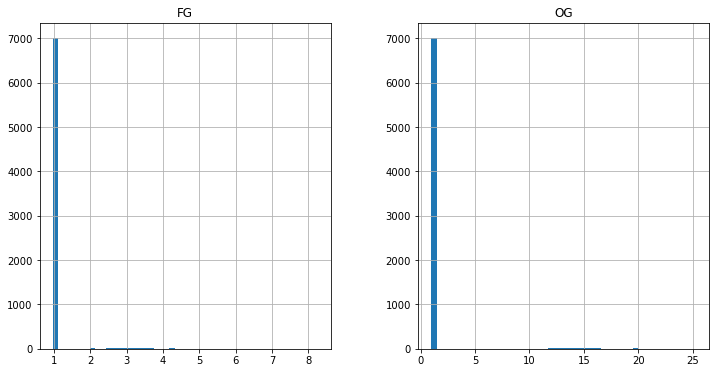

In [55]:
data_original[['OG', 'FG']].hist(bins=50, figsize=(12,6))

In [56]:
filters = (data.OG > 1.2) | (data.FG > 1.06)
filters.sum()

4

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4358084e50>,
      dtype=object)

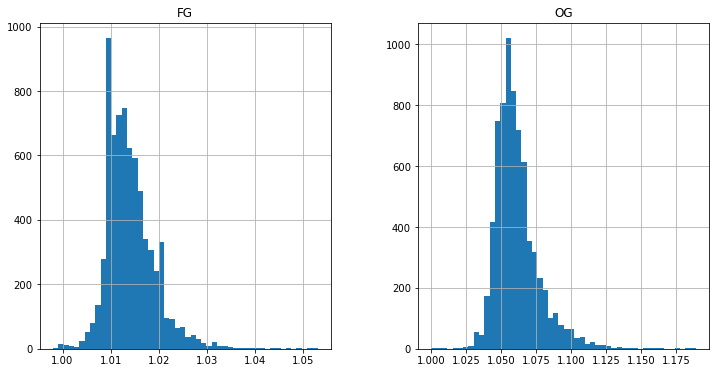

In [57]:
data.drop(index=data.index[filters])[['OG', 'FG']].hist(bins=50, figsize=(12,6))

In [58]:
data.drop(index=data.index[filters], inplace=True)

### size

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f43580242d0>,
      dtype=object)

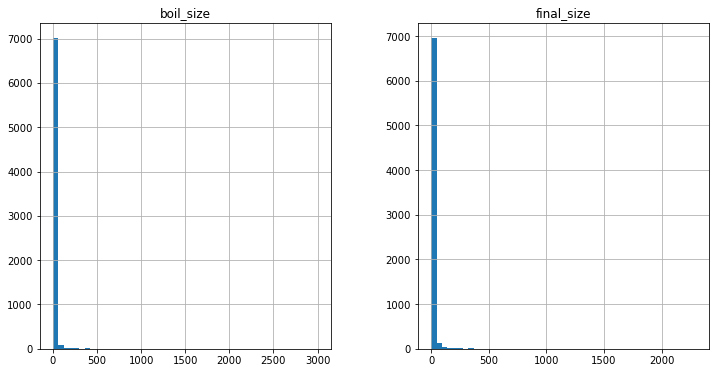

In [59]:
data_original[['boil_size', 'final_size']].hist(bins=50, figsize=(12,6))

In [60]:
filters = (data.boil_size > 150) | (data.final_size > 150)
filters.sum()

94

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4358162950>,
      dtype=object)

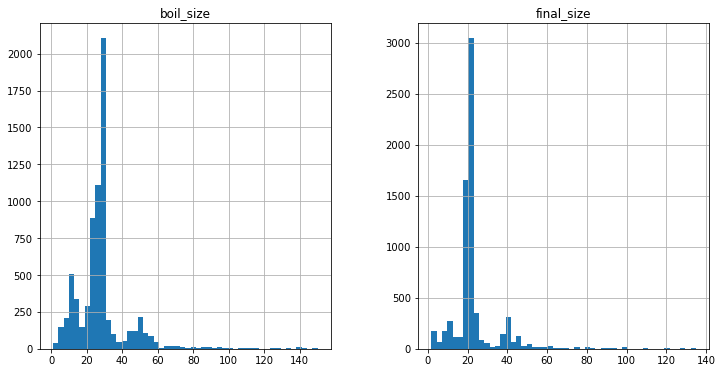

In [61]:
data.drop(index=data.index[filters])[['boil_size', 'final_size']].hist(bins=50, figsize=(12,6))

In [62]:
data.drop(index=data.index[filters], inplace=True)

### IBU

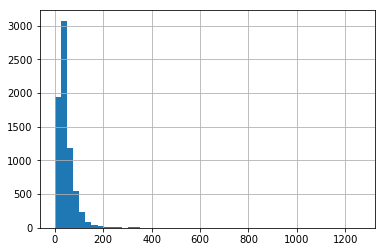

In [63]:
data_original.IBU.hist(bins=50)

In [64]:
filters = data.IBU > 150
filters.sum()

112

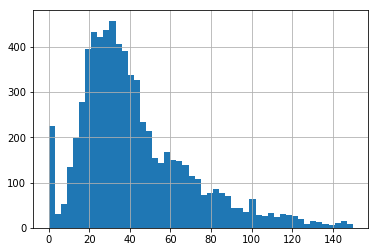

In [65]:
data.drop(index=data.index[filters]).IBU.hist(bins=50)

In [66]:
data.drop(index=data.index[filters], inplace=True)

### Calories and carbs

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f435452f990>,
      dtype=object)

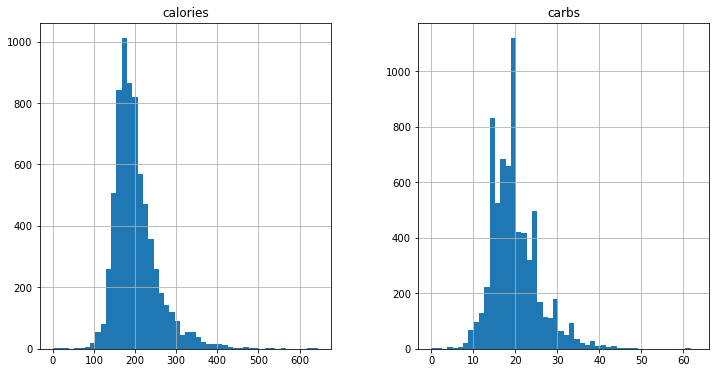

In [67]:
data[['calories', 'carbs']].hist(bins=50, figsize=(12,6))

In [68]:
filters = (data.calories > 500) | (data.carbs > 50)
filters.sum()

11

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4353dbb1d0>,
      dtype=object)

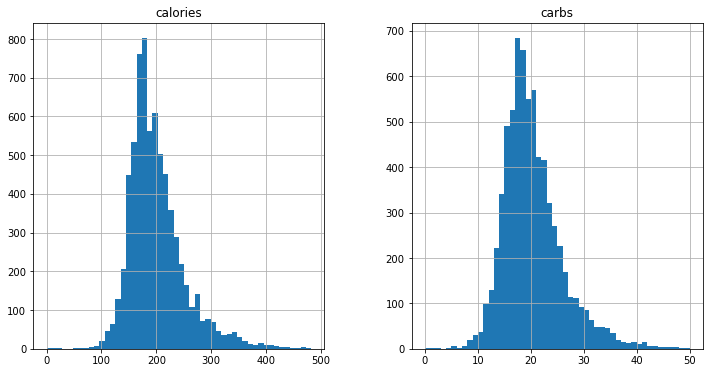

In [69]:
data.drop(index=data.index[filters])[['calories', 'carbs']].hist(bins=50, figsize=(12,6))

In [70]:
data.drop(index=data.index[filters], inplace=True)

### Mash PH

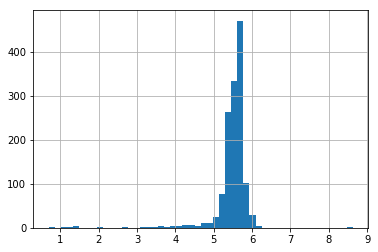

In [136]:
data_details.mash_ph.hist(bins=50)

In [191]:
filters = (data.mash_ph < 3.5) | (data.mash_ph > 7)
filters.sum()

13

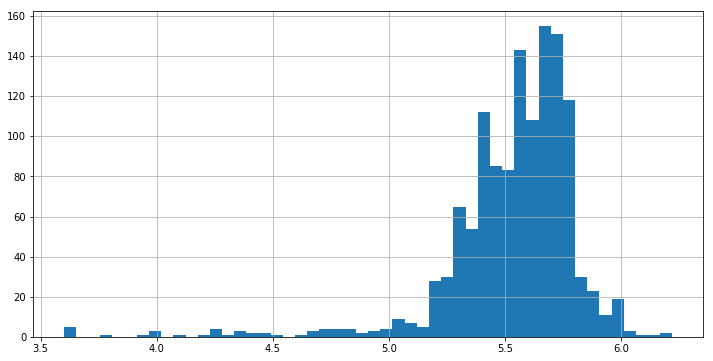

In [192]:
data.drop(index=data.index[filters])['mash_ph'].hist(bins=50, figsize=(12,6))

In [193]:
data.drop(index=data.index[filters], inplace=True)

### Mash thickness

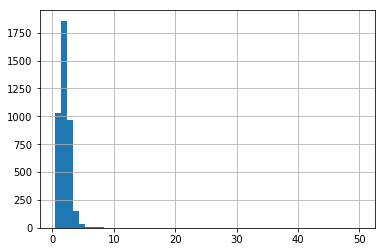

In [196]:
data_original.mash_thick.hist(bins=50)

In [199]:
filters = (data.mash_thick > 10)
filters.sum()

7

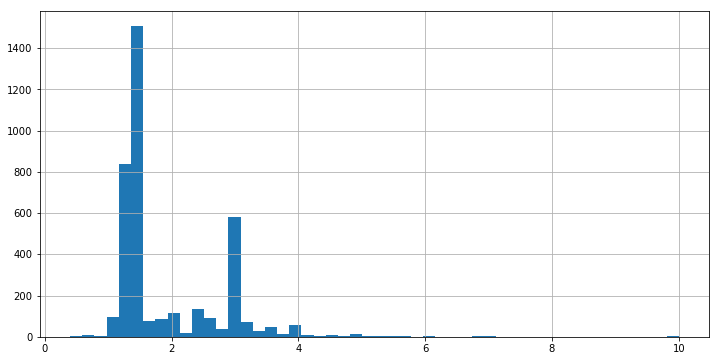

In [200]:
data.drop(index=data.index[filters])['mash_thick'].hist(bins=50, figsize=(12,6))

In [201]:
data.drop(index=data.index[filters], inplace=True)

In [225]:
len(data_original) - len(data)

266

In [226]:
len(data)

6913

# Feature engineering

## gravity

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4340ceb910>,
      dtype=object)

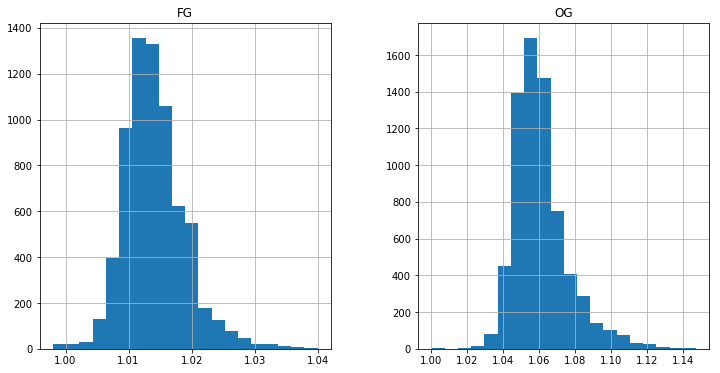

In [142]:
data[['OG', 'FG']].hist(bins=20, figsize=(12,6))

In [143]:
data['d_G_abs'] = data.OG - data.FG
data['d_G_pct'] = data.d_G_abs / data.OG

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4340ad1b10>,
      dtype=object)

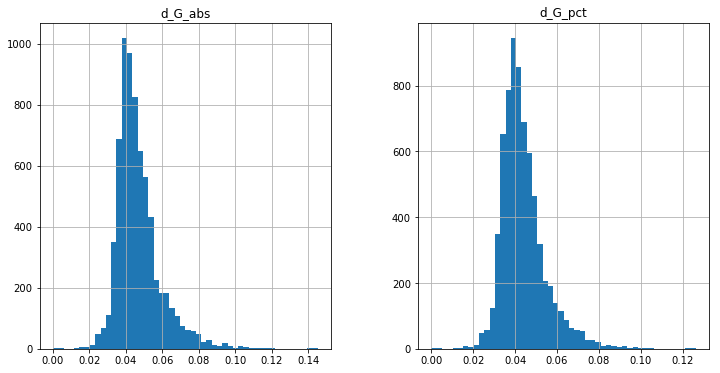

In [144]:
data[['d_G_abs', 'd_G_pct']].hist(bins=50, figsize=(12,6))

## size

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4340a65090>,
      dtype=object)

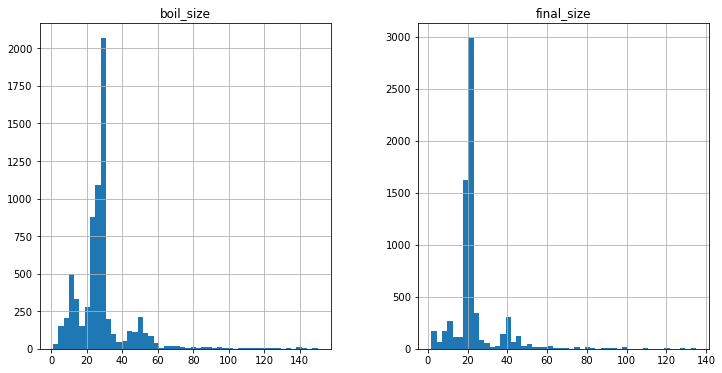

In [145]:
data[['boil_size', 'final_size']].hist(bins=50, figsize=(12,6))

In [146]:
data['d_size_abs'] = data.boil_size - data.final_size
data['d_size_pct'] = data.d_size_abs / data.boil_size

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f434097bd90>,
      dtype=object)

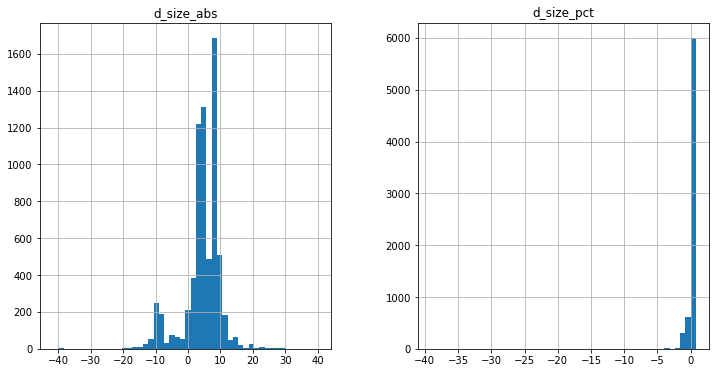

In [147]:
data[['d_size_abs', 'd_size_pct']].hist(bins=50, figsize=(12,6))

In [148]:
print((f'{np.sum(data.boil_size < data.final_size)} ({100*np.sum(data.boil_size < data.final_size)/len(data):.2f}%)' + 
       f' beers have boil sizes < final sizes...'
     ))

783 (11.25%) beers have boil sizes < final sizes...


In [149]:
data_original[data_original.boil_size < data_original.final_size].url_beer

30      https://www.brewersfriend.com/homebrew/recipe/...
32      https://www.brewersfriend.com/homebrew/recipe/...
33      https://www.brewersfriend.com/homebrew/recipe/...
34      https://www.brewersfriend.com/homebrew/recipe/...
39      https://www.brewersfriend.com/homebrew/recipe/...
                              ...                        
7152    https://www.brewersfriend.com/homebrew/recipe/...
7155    https://www.brewersfriend.com/homebrew/recipe/...
7157    https://www.brewersfriend.com/homebrew/recipe/...
7167    https://www.brewersfriend.com/homebrew/recipe/...
7168    https://www.brewersfriend.com/homebrew/recipe/...
Name: url_beer, Length: 808, dtype: object

In [219]:
(data.brewed == 2).sum() / len(data)

0.6134818457977723

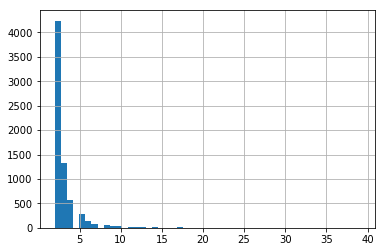

In [217]:
data[data.brewed < 40].brewed.hist(bins=50)

# Save data

In [254]:
data.to_csv('data/data_clean.csv')

# Visualize

In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6958 entries, 0 to 7178
Columns: 205 entries, title to d_size_pct
dtypes: float64(17), int64(12), object(2), uint8(174)
memory usage: 2.9+ MB


In [92]:
cat_cols = [col for col in data.columns if re.match(r'has_', col) or re.match(r'is_', col)]
con_cols = [col for col in data.columns 
            if col not in set(method_cols 
                              + style_cols 
                              + cat_cols 
                              + ['beer_style']
                              + ['title', 'views', 'rating', 'reviews', 'brewed'])
           ]
nan_cols = data.columns[data.isna().any(0)]
print(cat_cols, con_cols)

['has_prim_data', 'has_mash_ph', 'has_mash_thick', 'has_pitch_rate'] ['final_size', 'ABV', 'IBU', 'OG', 'FG', 'color', 'boil_size', 'boil_time', 'boil_grav', 'pitch_rate', 'temp_prim', 'efficiency', 'mash_thick', 'calories', 'carbs', 'mash_ph', 'd_G_abs', 'd_G_pct', 'd_size_abs', 'd_size_pct']


In [93]:
data[con_cols]

final_size    ABV     IBU     OG     FG  color  boil_size  boil_time  \
0      24.605177   5.58   40.12  1.055  1.013   8.00  29.336941         70   
1      21.766118   6.50   50.60  1.062  1.013   5.20  28.390588         60   
2      22.712471   5.94   54.57  1.061  1.016   8.50  26.497882         60   
3      18.927059   6.16   64.77  1.063  1.016   8.98  22.712471         60   
4       3.785412   6.10   37.06  1.058  1.011  11.45   5.678118         60   
...          ...    ...     ...    ...    ...    ...        ...        ...   
7174    9.463529   5.65   49.37  1.056  1.013   9.93  15.141647         75   
7175   20.819765   8.34  149.04  1.077  1.014   7.66  26.497882         75   
7176   22.712471   5.26   33.33  1.054  1.014  39.33  27.444235         60   
7177   20.819765  10.52  100.28  1.093  1.019   7.53  30.283294        120   
7178   20.819765   7.07   61.53  1.070  1.016   4.78  26.497882         60   

      boil_grav  pitch_rate  temp_prim  efficiency  mash_thick  calories  \
0         1.047        1.00        NaN          79         NaN       182   
1         1.048         NaN        NaN          70        1.25       204   
2         1.053         NaN        NaN          70         NaN       203   
3         1.052         NaN        NaN          70         NaN       208   
4         1.039        0.35  18.333333          55        1.50       190   
...         ...         ...        ...         ...         ...       ...   
7174        NaN         NaN        NaN          70         NaN       185   
7175        NaN         NaN        NaN          75         NaN       254   
7176        NaN         NaN        NaN          65         NaN       178   
7177      1.064         NaN  20.000000          69        1.20       308   
7178        NaN         NaN        NaN          75         NaN       232   

      carbs  mash_ph  d_G_abs   d_G_pct  d_size_abs  d_size_pct  
0        18     5.67    0.042  0.039810    4.731765    0.161290  
1        19     5.49    0.049  0.046139    6.624471    0.233333  
2        22     5.81    0.045  0.042413    3.785412    0.142857  
3        22     5.41    0.047  0.044214    3.785412    0.166667  
4        17      NaN    0.047  0.044423    1.892706    0.333333  
...     ...      ...      ...       ...         ...         ...  
7174     18      NaN    0.043  0.040720    5.678118    0.375000  
7175     22      NaN    0.063  0.058496    5.678118    0.214286  
7176     19      NaN    0.040  0.037951    4.731765    0.172414  
7177     28      NaN    0.074  0.067704    9.463529    0.312500  
7178     23      NaN    0.054  0.050467    5.678118    0.214286  

[6958 rows x 20 columns]

In [94]:
scaler = StandardScaler()
data_normed = data.copy()
data_normed.loc[:, con_cols] = scaler.fit_transform(data[con_cols])

### All data

In [240]:
cbar.

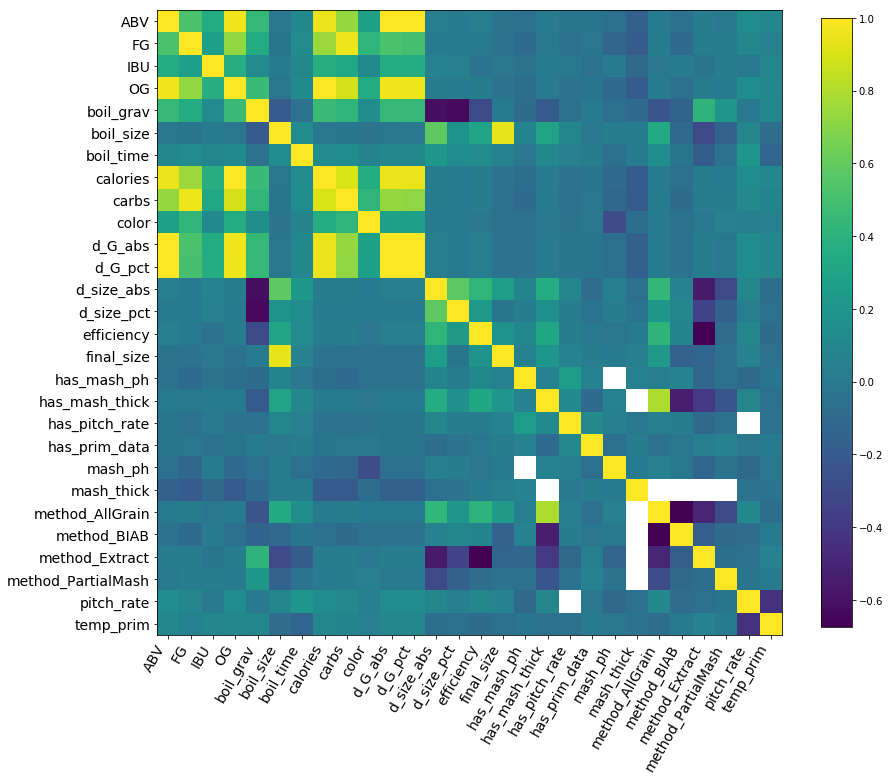

In [242]:
columns = sorted(con_cols + cat_cols + method_cols)

fig, ax = plt.subplots(figsize=(14,14))

im = ax.imshow(data[columns].corr())
ax.set_xticks(np.arange(len(columns)))
ax.set_xticklabels(columns, rotation=60, ha='right', fontsize=14)
ax.set_yticks(np.arange(len(columns)))
ax.set_yticklabels(columns, fontsize=14)

cbar = plt.colorbar(im, shrink=0.8)

plt.savefig('fig/corr_all.png')
plt.show()

0.16294148031442457


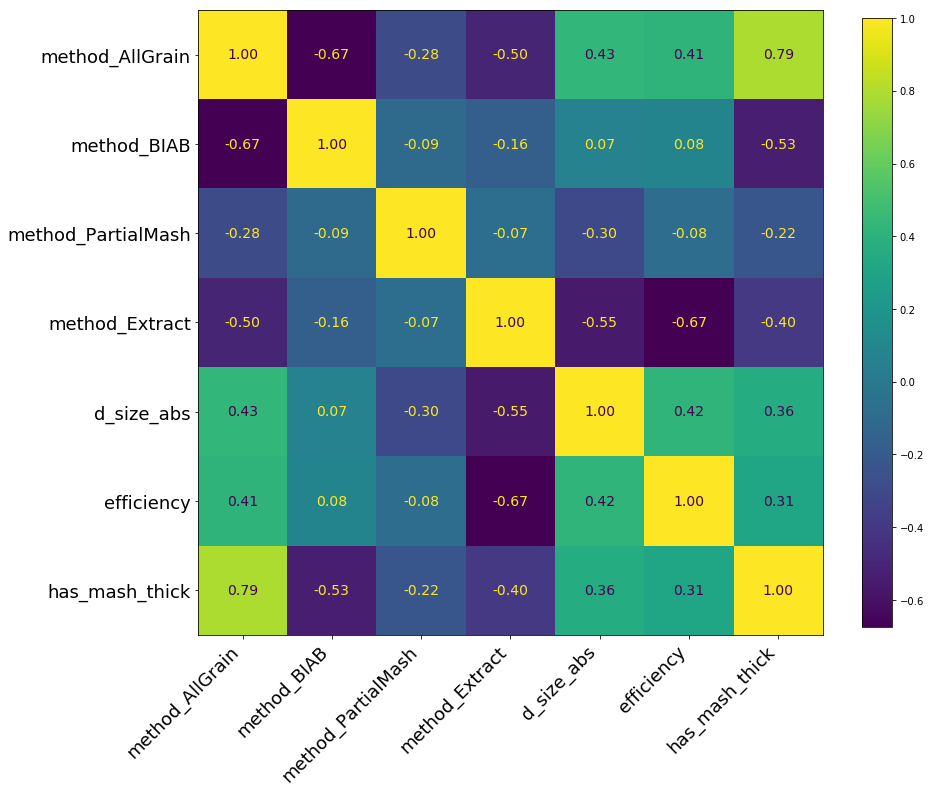

In [251]:
values_format = '.2f'

columns = ['method_AllGrain','method_BIAB','method_PartialMash','method_Extract','d_size_abs','efficiency','has_mash_thick']
filters = (data[columns].isna().any(axis=1) == False)
corr = data.loc[filters, columns].corr().values

fig, ax = plt.subplots(figsize=(14,14))
im = ax.imshow(corr)
cmap_min, cmap_max = im.cmap(0), im.cmap(256)
texts = np.empty_like(corr, dtype=object)
if values_format is None:
    values_format = '.2g'

# print text with appropriate color depending on background
thresh = (corr.max() + corr.min()) / 2.
print(thresh)
for i, j in itertools.product(range(corr.shape[0]), range(corr.shape[1])):
    color = cmap_max if corr[i, j] < thresh else cmap_min
    texts[i, j] = ax.text(j, i,
                          format(corr[i, j], values_format),
                          ha='center', va="center",
                          fontsize=14,
                          color=color)

ax.set_xticks(np.arange(len(columns)))
ax.set_xticklabels(columns, rotation=45, ha='right', fontsize=18)
ax.set_yticks(np.arange(len(columns)))
ax.set_yticklabels(columns, fontsize=18)

plt.colorbar(im, shrink=0.8)

plt.savefig('fig/corr_method.png')
plt.show()

In [253]:
data.calories.isna().sum()

0

0.7519644985906567


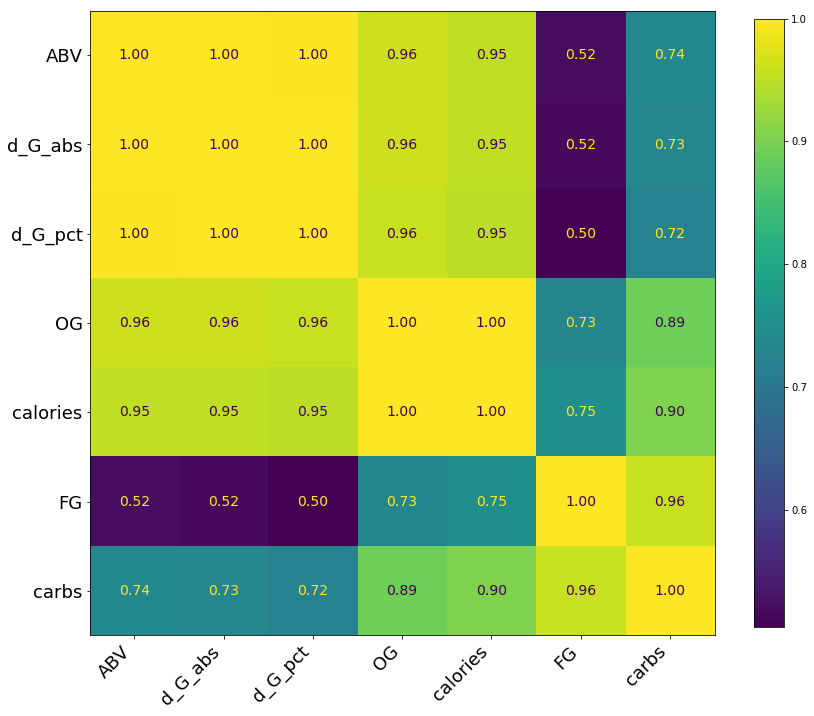

In [247]:
values_format = '.2f'

columns = ['ABV','d_G_abs','d_G_pct','OG','calories','FG','carbs']
filters = (data[columns].isna().any(axis=1) == False)
corr = data.loc[filters, columns].corr().values

fig, ax = plt.subplots(figsize=(14,14))
im = ax.imshow(corr)
cmap_min, cmap_max = im.cmap(0), im.cmap(256)
texts = np.empty_like(corr, dtype=object)
if values_format is None:
    values_format = '.2g'

# print text with appropriate color depending on background
thresh = (corr.max() + corr.min()) / 2.
print(thresh)
for i, j in itertools.product(range(corr.shape[0]), range(corr.shape[1])):
    color = cmap_max if corr[i, j] < thresh else cmap_min
    texts[i, j] = ax.text(j, i,
                          format(corr[i, j], values_format),
                          ha='center', va="center",
                          fontsize=14,
                          color=color)

ax.set_xticks(np.arange(len(columns)))
ax.set_xticklabels(columns, rotation=45, ha='right', fontsize=18)
ax.set_yticks(np.arange(len(columns)))
ax.set_yticklabels(columns, fontsize=18)

plt.colorbar(im, shrink=0.8)

plt.savefig('fig/corr_grav.png')
plt.show()

### With filters

In [843]:
filters = (data.mash_thick.isna() == False) & (data.temp_prim.isna() == False)
filters.sum()

2841

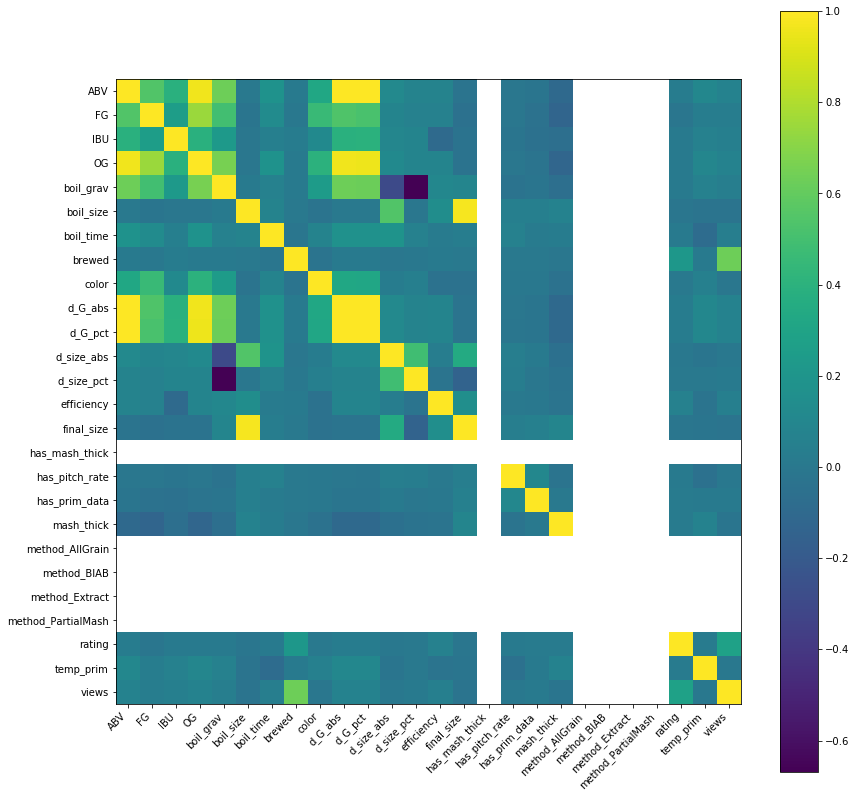

In [845]:
columns = sorted(con_cols.union(cat_cols).union(method_cols).union(['rating', 'views', 'brewed']) 
                 - set(['pitch_rate']))

fig, ax = plt.subplots(figsize=(14,14))

im = ax.imshow(data.loc[filters, columns].corr())
ax.set_xticks(np.arange(len(columns)))
ax.set_xticklabels(columns, rotation=45, ha='right')
ax.set_yticks(np.arange(len(columns)))
ax.set_yticklabels(columns)

plt.colorbar(im)

plt.show()

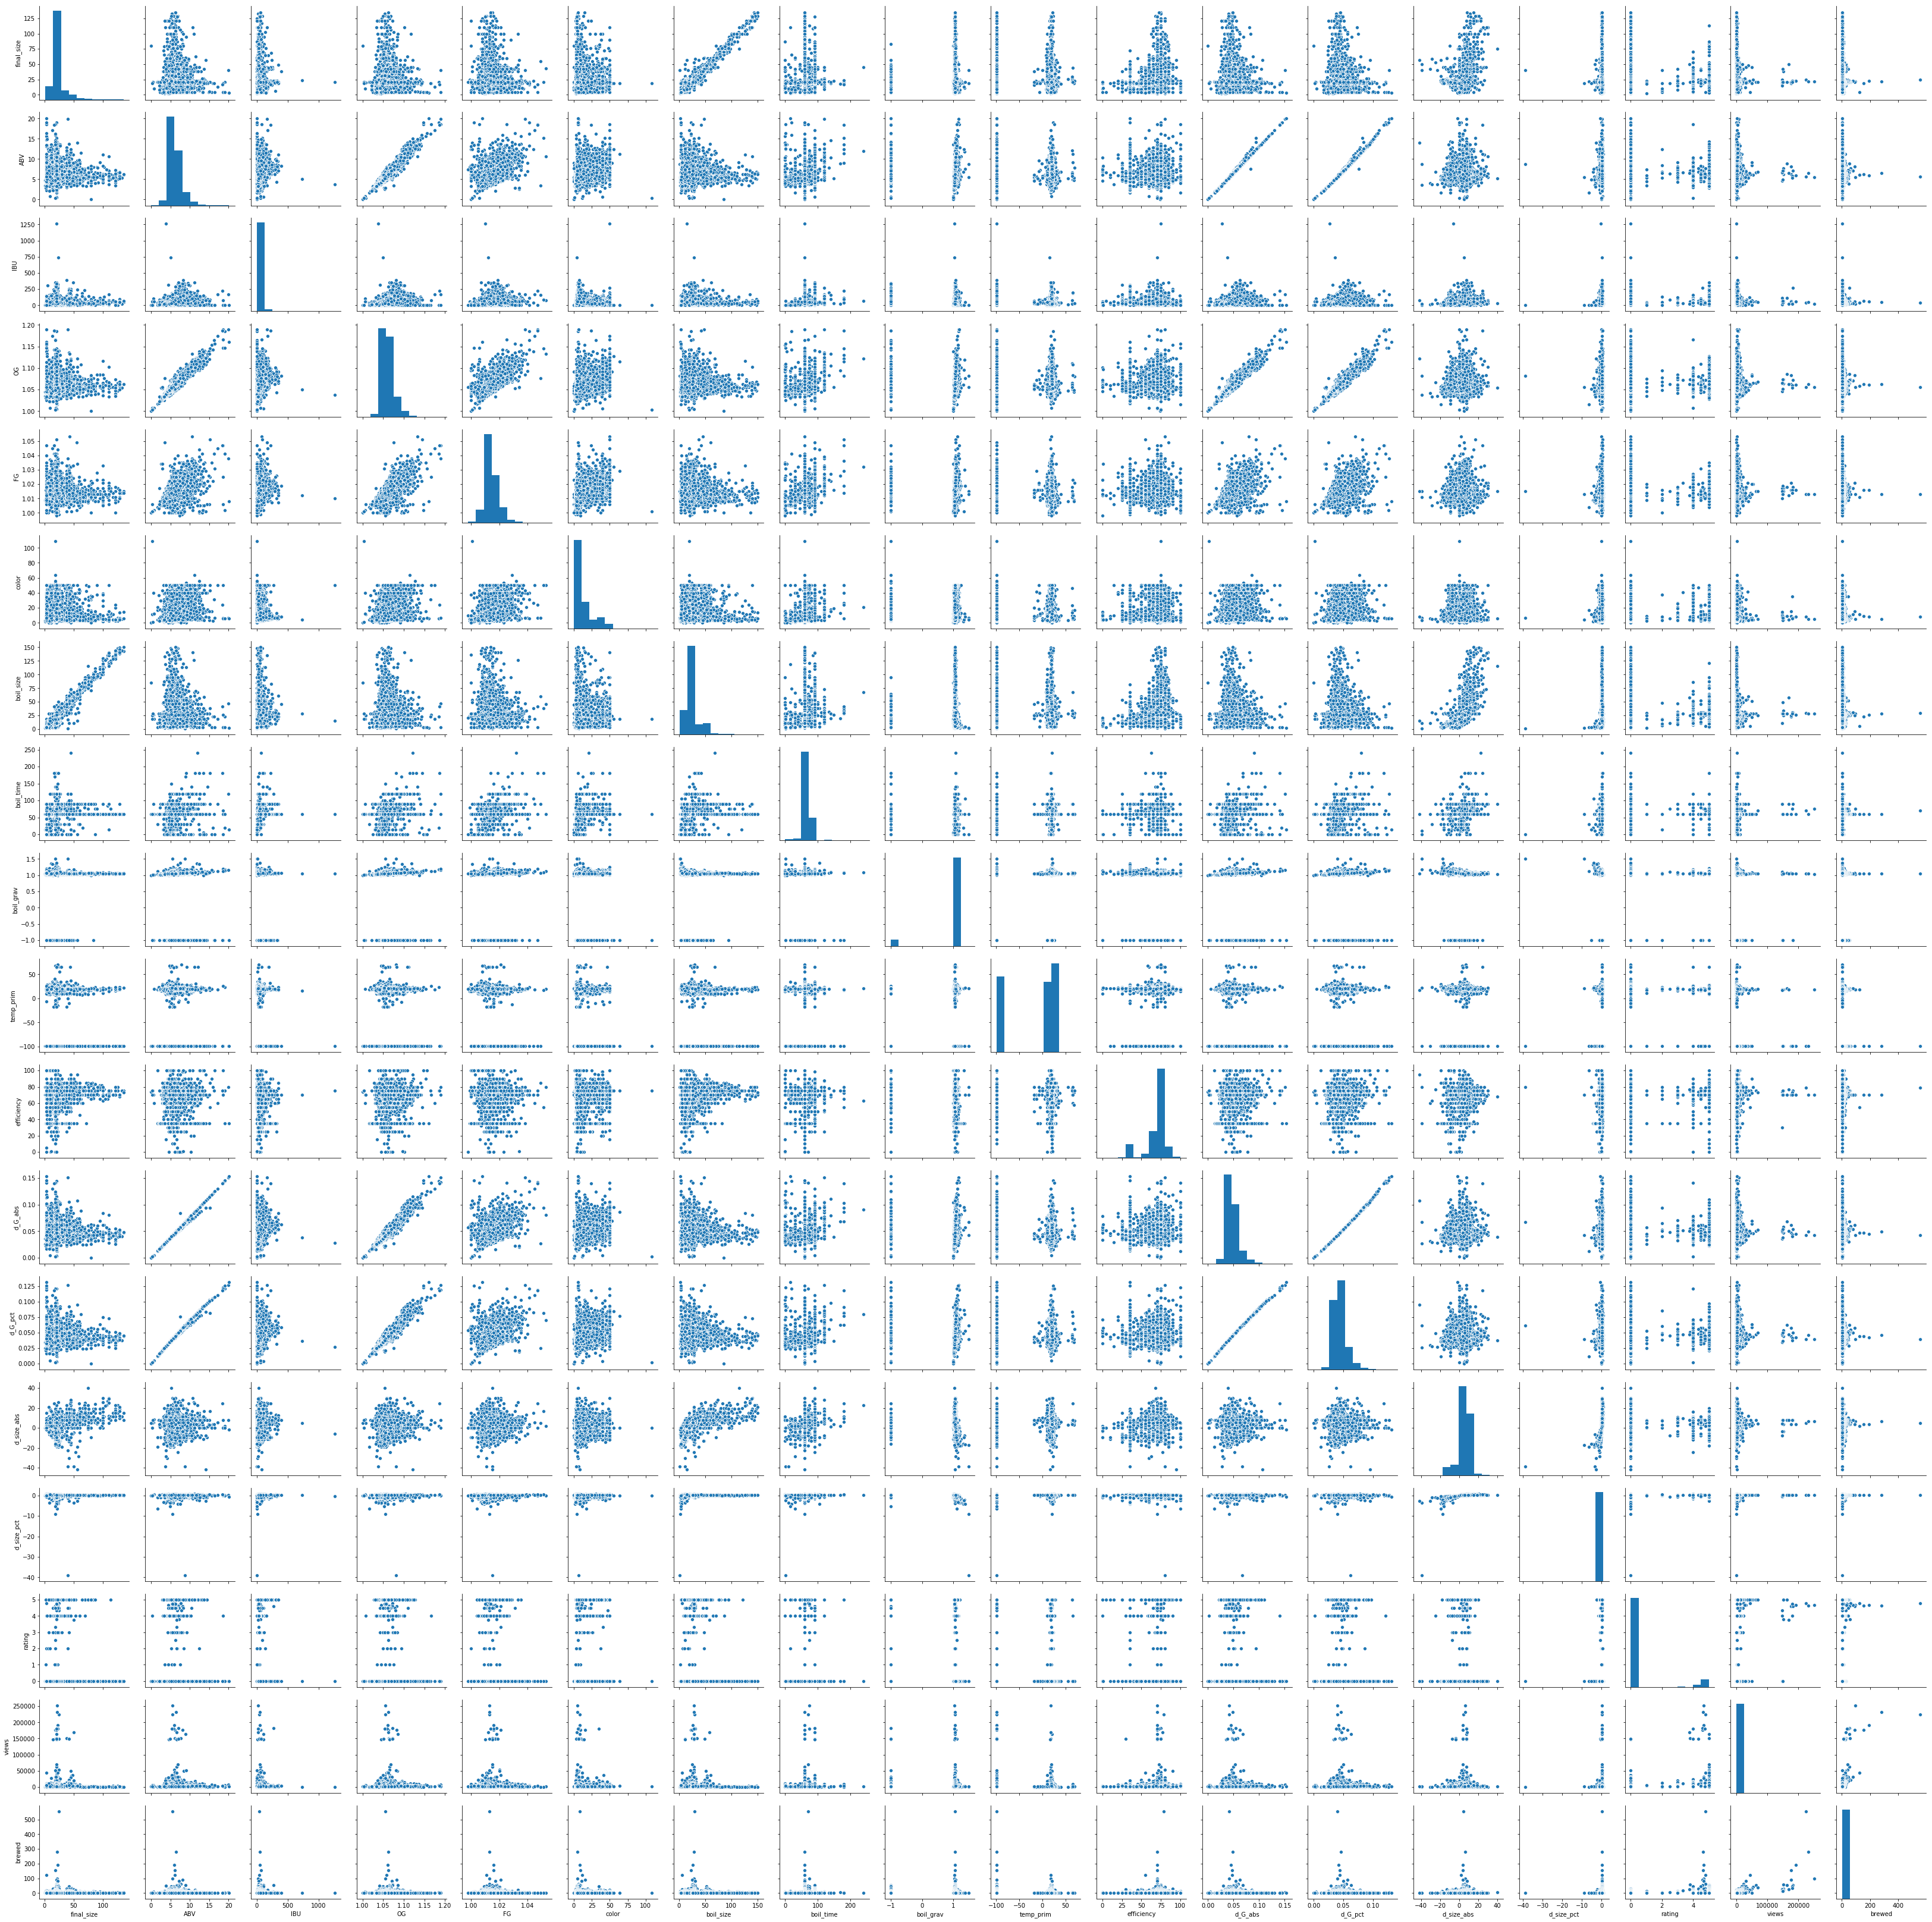

In [581]:
sns.pairplot(data[con_cols + ['rating', 'views', 'brewed']])

## UMAP

/home/tandemelephant/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


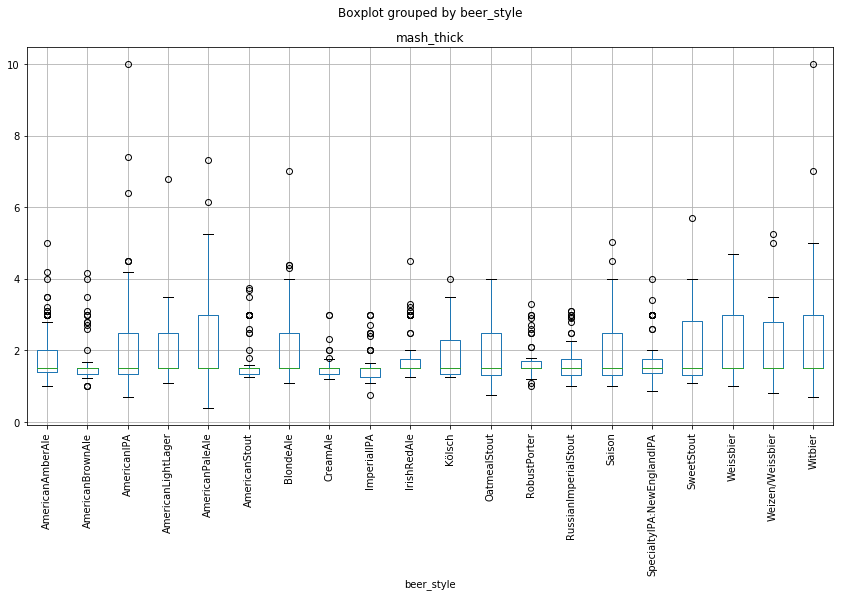

In [202]:
data[under_threshold == False].boxplot(column='mash_thick', by='beer_style', figsize=(14,7), rot=90)

In [151]:
from umap import UMAP

In [221]:
print(con_cols)

['final_size', 'ABV', 'IBU', 'OG', 'FG', 'color', 'boil_size', 'boil_time', 'boil_grav', 'pitch_rate', 'temp_prim', 'efficiency', 'mash_thick', 'calories', 'carbs', 'mash_ph', 'd_G_abs', 'd_G_pct', 'd_size_abs', 'd_size_pct']


In [152]:
nan_cols

Index(['boil_grav', 'pitch_rate', 'temp_prim', 'mash_thick', 'mash_ph'], dtype='object')

In [100]:
data.temp_prim.isna().sum()

2225

In [153]:
filters = (data.temp_prim.isna() == False) & (data.)

In [154]:
n_neighbors = 50
columns = list(set(con_cols) - set(nan_cols) - set([''])) + ['temp_prim']

reducer = UMAP(random_state=42, n_neighbors=n_neighbors)
reducer_normed = UMAP(random_state=42, n_neighbors=n_neighbors)
X = reducer.fit_transform(data.loc[filters, columns])
X_normed = reducer_normed.fit_transform(data_normed.loc[filters, columns])

/home/tandemelephant/anaconda3/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../home/tandemelephant/anaconda3/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/tandemelephant/anaconda3/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../home/

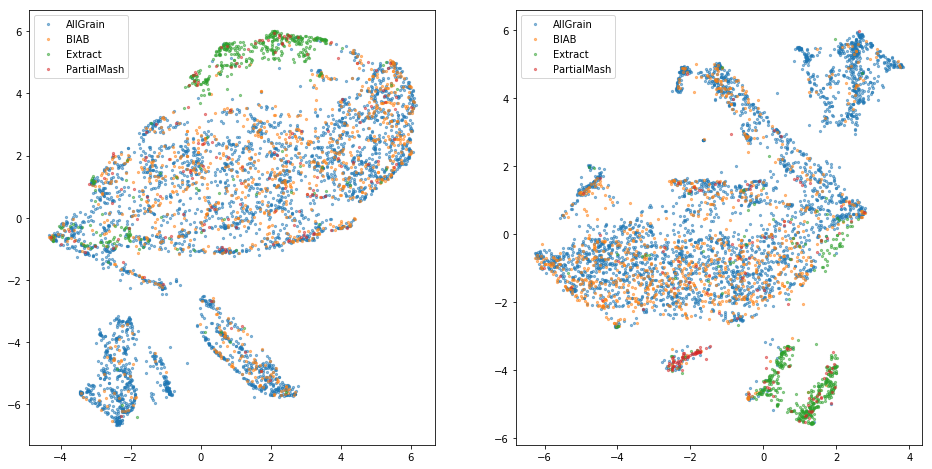

In [156]:
alpha=0.5

fig, ax = plt.subplots(1, 2, figsize=(16,8))

for method in method_cols:
    ax[0].scatter(X[(data[filters][method] == 1), 0], X[data[filters][method] == 1, 1], 
               alpha=alpha, marker='.', s=20,
               label=method.replace('method_',''))
    ax[0].legend()
    
    ax[1].scatter(X_normed[data[filters][method] == 1, 0], X_normed[data[filters][method] == 1, 1], 
               alpha=alpha, marker='.', s=20,
               label=method.replace('method_',''))
    ax[1].legend()

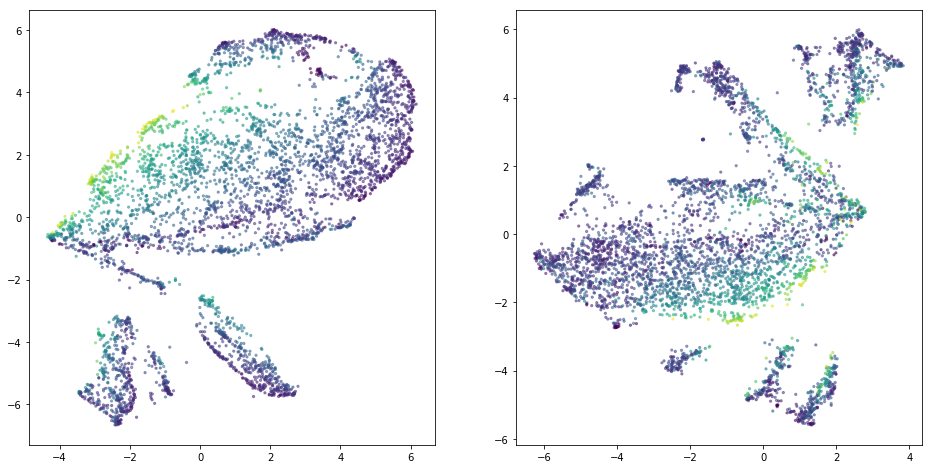

In [157]:
alpha=0.5

fig, ax = plt.subplots(1, 2, figsize=(16,8))

ax[0].scatter(X[:, 0], X[:, 1],
              c=data[filters].IBU,
              alpha=alpha, marker='.', s=20
             )
                

ax[1].scatter(X_normed[:, 0], X_normed[:, 1], 
              c=data[filters].IBU,
              alpha=alpha, marker='.', s=20
             )

plt.show()

### Method

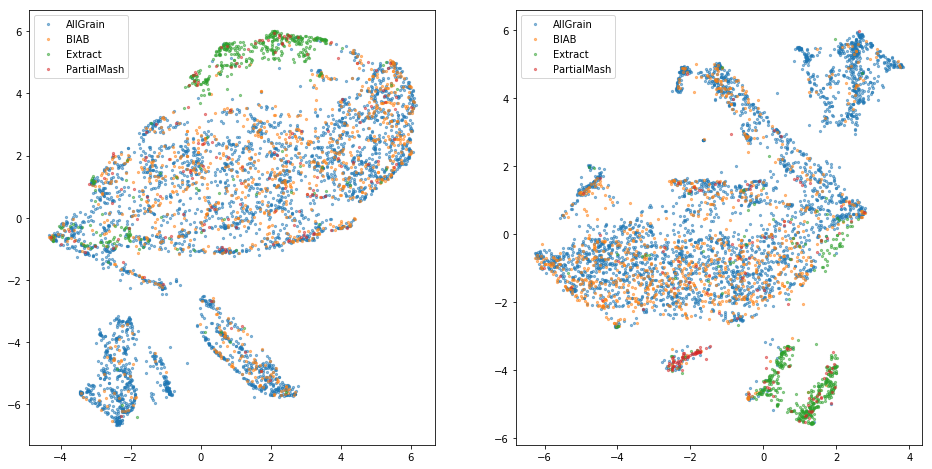

In [163]:
alpha=0.5

fig, ax = plt.subplots(1, 2, figsize=(16,8))

for method in method_cols:
    ax[0].scatter(X[(data[filters][method] == 1), 0], X[data[filters][method] == 1, 1], 
               alpha=alpha, marker='.', s=20,
               label=method.replace('method_',''))
    ax[0].legend()
    
    ax[1].scatter(X_normed[data[filters][method] == 1, 0], X_normed[data[filters][method] == 1, 1], 
               alpha=alpha, marker='.', s=20,
               label=method.replace('method_',''))
    ax[1].legend()

In [614]:
data.method_AllGrain.value_counts()

1    4760
0    2321
Name: method_AllGrain, dtype: int64

### Categorical cols 

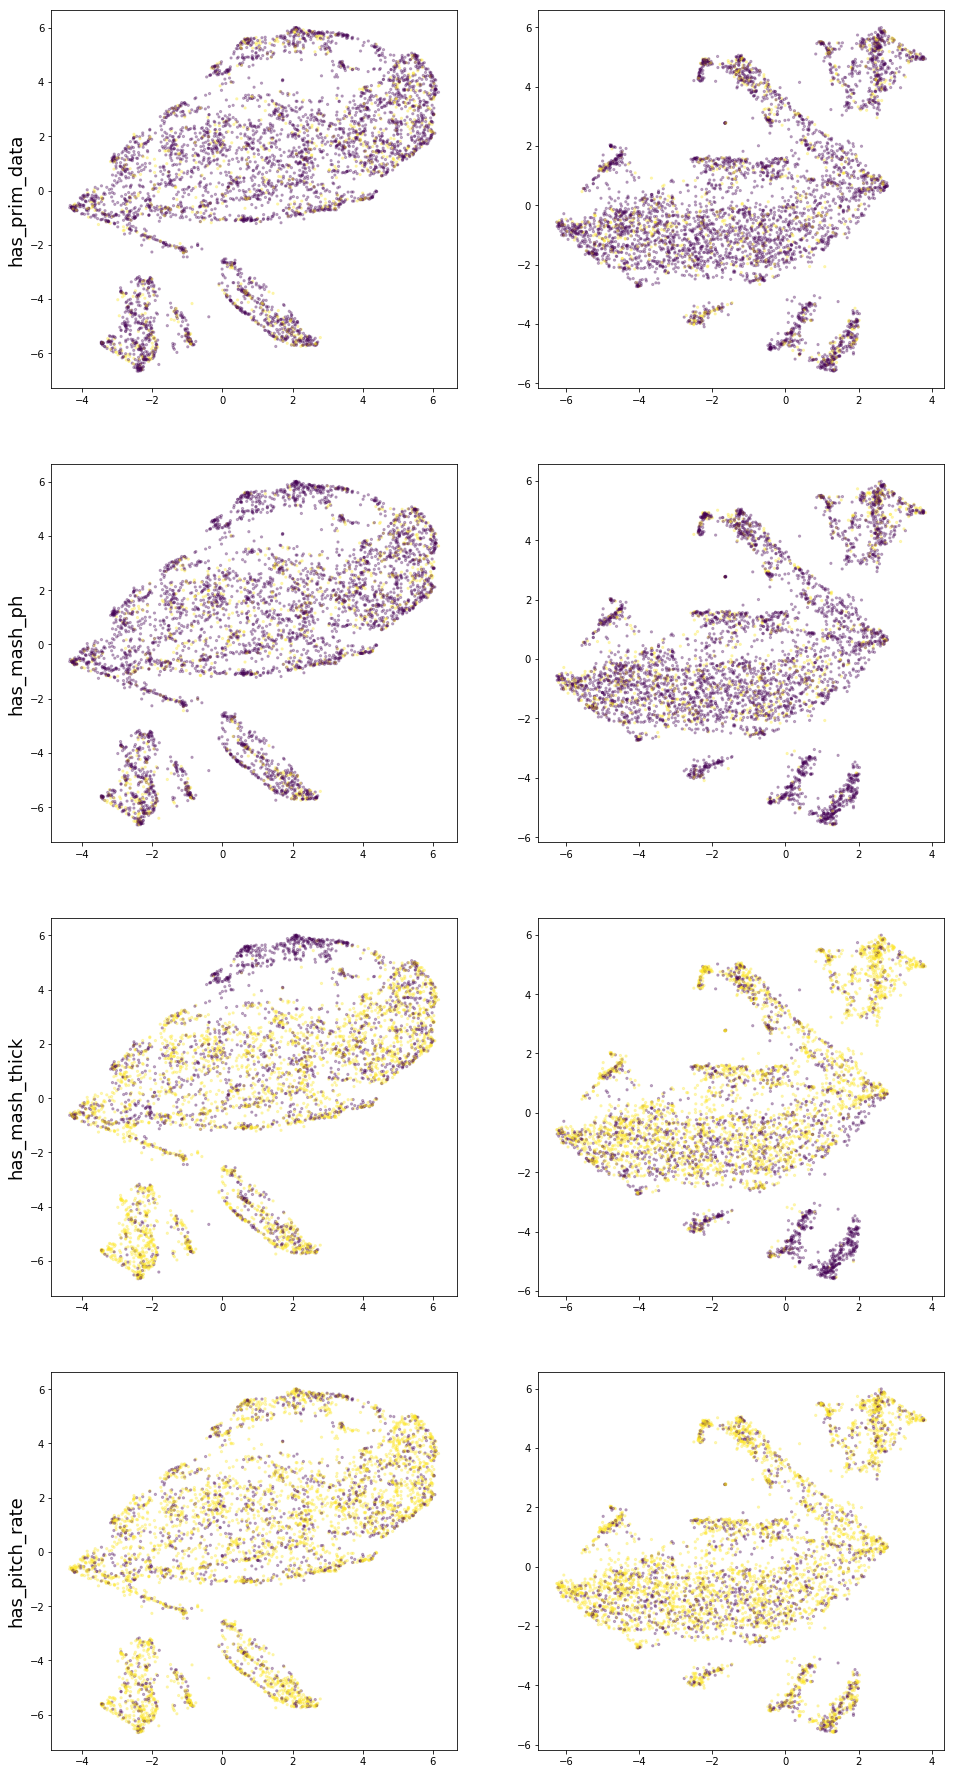

In [167]:
alpha=0.3

nrows = len(cat_cols)
fig, ax = plt.subplots(nrows, 2, figsize=(16, nrows*8))

for i, col in enumerate(cat_cols):
    ax[i, 0].scatter(X[:, 0], X[:, 1], 
                     c=data.loc[filters, col],
                     alpha=alpha, marker='.', s=20)
    ax[i, 0].set_ylabel(col, fontsize=18)
    ax[i, 1].scatter(X_normed[:, 0], X_normed[:, 1], 
                     c=data.loc[filters, col],
                     alpha=alpha, marker='.', s=20)

In [169]:
(data.has_pitch_rate == 0).sum()

2739

### Style

In [170]:
['style_' + col.replace(' ','') for col in list(style_counts.index[:5])]

['style_AmericanIPA',
 'style_AmericanPaleAle',
 'style_BlondeAle',
 'style_AmericanAmberAle',
 'style_Saison']

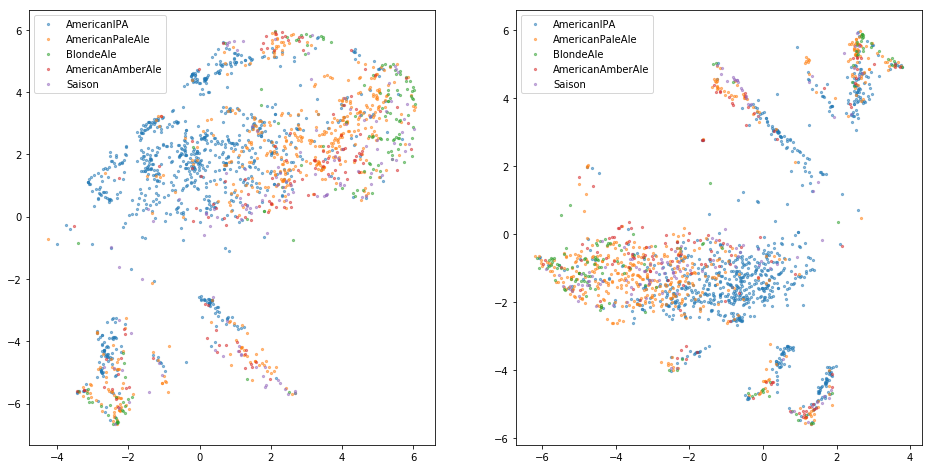

In [174]:
alpha=0.5
n_styles=5

data_tmp = data.loc[filters]
style_counts = data_tmp.beer_style.value_counts()
cols = ['style_' + col.replace(' ','') for col in list(style_counts.index[:n_styles])]

fig, ax = plt.subplots(1, 2, figsize=(16,8))

# ax[0].scatter(X[(data_tmp[cols] == 0).all(axis=1), 0], X[(data_tmp[cols] == 0).all(axis=1), 1], 
#                alpha=alpha/2, marker='.', s=20, color='grey',
#                label=f'Not in top {n_styles}')
# ax[0].legend()
# ax[1].scatter(X_normed[(data_tmp[cols] == 0).all(axis=1), 0], X_normed[(data_tmp[cols] == 0).all(axis=1), 1], 
#                alpha=alpha/2, marker='.', s=20, color='grey',
#                label=f'Not in top {n_styles}')
# ax[1].legend()

for style in cols:
    ax[0].scatter(X[data_tmp[style] == 1, 0], X[data_tmp[style] == 1, 1], 
               alpha=alpha, marker='.', s=20,
               label=style.replace('style_',''))
    ax[0].legend()
    
    ax[1].scatter(X_normed[data_tmp[style] == 1, 0], X_normed[data_tmp[style] == 1, 1], 
               alpha=alpha, marker='.', s=20,
               label=style.replace('style_',''))
    ax[1].legend()


plt.show()